In [24]:
#import pyCGM.metrics as cgm
import pandas as pd
import numpy as np
import copy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import sys
sys.path.append("/Users/cr591/OneDrive - University of Exeter/Desktop/pyCGM/pyCGM")
import metrics as cgm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, Matern, ConstantKernel as C
import sklearn.gaussian_process.kernels as k

In [60]:
import GPy as gpy

In [2]:
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta as time
fift_mins = time(minutes=15)
thirt_mins = time(minutes=30)

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('dexcom_data_rounded_5_min_interpolated.csv')

In [5]:
df = df.dropna(subset=['glc'])
df = df.dropna(subset=['cut_glc_pchip'])

In [177]:
df['time'] = pd.to_datetime(df.time)

In [7]:
df['timestamp'] = df.time.apply(lambda x: x.timestamp())

In [436]:
df.head()

,time,glc,ID,cut_glc,glc_linear,glc_pchip,glc_spline,glc_akima,glc_poly_5,glc_poly_3,cut_glc_linear,cut_glc_pchip,cut_glc_spline,cut_glc_akima,cut_glc_poly_5,cut_glc_poly_3,timestamp
0,2018-09-12 15:24:00,15.43,2005_6months,15.43,15.43,15.43,15.43,15.43,15.43,15.43,15.430000,15.430000,15.430000,15.430000,15.430000,15.430000,1.536766e+09
5,2018-09-12 15:29:00,15.54,2005_6months,NaN,15.54,15.54,15.54,15.54,15.54,15.54,15.483333,15.542593,15.832199,15.650864,16.171024,15.832199,1.536766e+09
10,2018-09-12 15:34:00,15.43,2005_6months,NaN,15.43,15.43,15.43,15.43,15.43,15.43,15.536667,15.584074,15.846426,15.718395,16.060447,15.846426,1.536766e+09
15,2018-09-12 15:39:00,15.59,2005_6months,15.59,15.59,15.59,15.59,15.59,15.59,15.59,15.590000,15.590000,15.590000,15.590000,15.590000,15.590000,1.536767e+09
20,2018-09-12 15:44:00,15.26,2005_6months,NaN,15.26,15.26,15.26,15.26,15.26,15.26,15.183333,15.321611,15.180241,15.214749,15.065781,15.180241,1.536767e+09


In [491]:
total_results = pd.DataFrame()
i=0
for ID in set(df.ID):
    print(ID)
    print(i)
    i += 1
    idsingle = df[df.ID == ID]
    y = idsingle.dropna().cut_glc
    X = np.atleast_2d(idsingle.dropna().timestamp).T
    x1 = idsingle.timestamp
    
    kernel = k.RBF(length_scale=400, length_scale_bounds=(400, 1500))
    kernel2 = k.RBF(length_scale=400, length_scale_bounds=(400, 800))
    kernel3 = k.RBF(length_scale=400, length_scale_bounds=(400, 900))
    
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X, y)
    y_mean, y_std = gp.predict(x1[:, None], return_std=True)
    
    idsingle['gauss_1000'] = y_mean
    
    gp = GaussianProcessRegressor(kernel=kernel2)
    gp.fit(X, y)
    y_mean, y_std = gp.predict(x1[:, None], return_std=True)
    
    idsingle['gauss_800'] = y_mean
    
    gp = GaussianProcessRegressor(kernel=kernel3)
    gp.fit(X, y)
    y_mean, y_std = gp.predict(x1[:, None], return_std=True)
    
    idsingle['gauss_900'] = y_mean
    
    kernel4 = Matern(10, (1, 2500), 1)
    gp = GaussianProcessRegressor(kernel=kernel4, n_restarts_optimizer=10)
    gp.fit(X, y)
    print(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}")

    y_mean, y_std = gp.predict(x1[:, None], return_std=True)
    
    idsingle['matern_2500'] = y_mean
    
    kernel5 = Matern(10, (1, 1600), 1)
    gp = GaussianProcessRegressor(kernel=kernel5, n_restarts_optimizer=10)
    gp.fit(X, y)
    print(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}")

    y_mean, y_std = gp.predict(x1[:, None], return_std=True)
    
    idsingle['matern1600'] = y_mean
    
    kernel6 = Matern(10, (1, 2000), 1)
    gp = GaussianProcessRegressor(kernel=kernel6, n_restarts_optimizer=10)
    gp.fit(X, y)
    print(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}")

    y_mean, y_std = gp.predict(x1[:, None], return_std=True)
    
    idsingle['matern200'] = y_mean
    
    total_results = total_results.append(idsingle)

2026_baseline
0
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
1004_baseline
1
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
1007_baseline
2
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
1045_6months
3
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
2043_6months
4
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
1051_6months
5
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
2042_6months
6
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
2011_6months
7
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
2019_6months
8
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
2023_6months
9
RBF, length_scale=2500.000
RBF, length_scale=1800.000
RBF, length_scale=2000.000
1012_baseline
10
RBF, length_scale=25

In [104]:
total_results = pd.DataFrame()
i=0
for ID in set(df.ID):
    print('')
    print('')
    print(ID)
    print(i)
    i += 1
    idsingle = df[df.ID == ID]
    #idsingle_test = idsingle[pd.isnull(idsingle.cut_glc)]
    
    Y_train = idsingle.dropna().cut_glc
    X_train = np.atleast_2d(idsingle.dropna(subset=['cut_glc']).timestamp).T
    
    X_test = idsingle.timestamp
    Y_test = idsingle.glc
    
    rbf_kernel = k.RBF(length_scale=400, length_scale_bounds=(400, 10000))
    rbf_900 = k.RBF(length_scale = 900, length_scale_bounds='fixed')
    rq_kernel = k.RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), 
                                    alpha_bounds=(1e-05, 100000.0))
    matern3 = k.Matern(length_scale=1.3e4, length_scale_bounds=(1e3, 100000.0), nu=0.5)
    matern4 = k.Matern(length_scale=1e4, length_scale_bounds='fixed', nu=1)
    
    
    kernels = {'matern3': matern3, 'matern4', matern4, 'rbf900': rbf_900, 'rq': rq_kernel} #rbf_kernel, rq_kernel,rbf_900
    #kernel3 = k.RBF(length_scale=400, length_scale_bounds=(400, 900))
    
    for kernel in kernels:
        print(kernel)
        gp = GaussianProcessRegressor(kernel=kernels[kernel], n_restarts_optimizer=5) # , normalize_y=True)
        gp.fit(X_train, Y_train)
        y_mean, y_std = gp.predict(X_test[:, None], return_std=True)

        idsingle[kernel] = y_mean

        print(gp.kernel_)
        print(mean_absolute_error(Y_test, y_mean))
        print('')
        
    total_results = total_results.append(idsingle)



2012_6months
0
matern3
Matern(length_scale=1e+04, nu=0.5)
0.10923248549464143



1034_baseline
1
matern3
Matern(length_scale=1.67e+04, nu=0.5)
0.04654970814711465



2029_6months
2
matern3
Matern(length_scale=1.13e+04, nu=0.5)
0.08201184219325301



2024_6months
3
matern3
Matern(length_scale=1.11e+04, nu=0.5)
0.07635355739175265



1003_6months
4
matern3
Matern(length_scale=1.37e+04, nu=0.5)
0.07715321731986112



2042_6months
5
matern3
Matern(length_scale=1.17e+04, nu=0.5)
0.09411498071770184



2040_6months
6
matern3
Matern(length_scale=1.38e+04, nu=0.5)
0.08162921614712026



2031_6months
7
matern3
Matern(length_scale=1.15e+04, nu=0.5)
0.09843499138633616



1012_6months
8
matern3
Matern(length_scale=2.13e+04, nu=0.5)
0.08837311004070625



1004_baseline
9
matern3
Matern(length_scale=1.13e+04, nu=0.5)
0.0813656107435798



1019_6months
10
matern3
Matern(length_scale=1.11e+04, nu=0.5)
0.08898870743088076



2023_6months
11
matern3
Matern(length_scale=1.16e+04, nu=0.5)
0.08231522840

In [106]:
total_results.to_csv('dexcom_gauss_matern.csv')

In [90]:
total_results.head(1000)

,time,glc,ID,cut_glc,glc_linear,glc_pchip,glc_spline,glc_akima,glc_poly_5,glc_poly_3,cut_glc_linear,cut_glc_pchip,cut_glc_spline,cut_glc_akima,cut_glc_poly_5,cut_glc_poly_3,timestamp,rbf900,rq,matern6
74601,2018-09-12 13:31:00,5.17,2012_6months,5.17,5.17,5.17,5.17,5.17,5.17,5.17,5.170000,5.170000,5.170000,5.170000,5.170000,5.170000,1.536759e+09,5.170000,5.170000,5.170022
74606,2018-09-12 13:36:00,4.94,2012_6months,NaN,4.94,4.94,4.94,4.94,4.94,4.94,5.373333,5.488889,5.735699,5.469123,6.115333,5.735699,1.536759e+09,5.696231,5.377019,5.417894
74611,2018-09-12 13:41:00,5.67,2012_6months,NaN,5.67,5.67,5.67,5.67,5.67,5.67,5.576667,5.702222,5.887670,5.662690,6.127963,5.887670,1.536760e+09,5.879215,5.647299,5.653771
74616,2018-09-12 13:46:00,5.78,2012_6months,5.78,5.78,5.78,5.78,5.78,5.78,5.78,5.780000,5.780000,5.780000,5.780000,5.780000,5.780000,1.536760e+09,5.780000,5.780000,5.779935
74621,2018-09-12 13:51:00,5.89,2012_6months,NaN,5.89,5.89,5.89,5.89,5.89,5.89,5.666667,5.691852,5.566774,5.699457,5.439592,5.566774,1.536760e+09,5.552677,5.670194,5.651747
74626,2018-09-12 13:56:00,5.83,2012_6months,NaN,5.83,5.83,5.83,5.83,5.83,5.83,5.553333,5.528148,5.402079,5.484060,5.305222,5.402079,1.536761e+09,5.388647,5.463137,5.473478
74631,2018-09-12 14:01:00,5.44,2012_6months,5.44,5.44,5.44,5.44,5.44,5.44,5.44,5.440000,5.440000,5.440000,5.440000,5.440000,5.440000,1.536761e+09,5.440000,5.440000,5.440095
74636,2018-09-12 14:06:00,5.78,2012_6months,NaN,5.78,5.78,5.78,5.78,5.78,5.78,5.886667,5.759411,5.777944,5.792285,5.805964,5.777944,1.536761e+09,5.754724,5.769048,5.801629
74641,2018-09-12 14:11:00,6.28,2012_6months,NaN,6.28,6.28,6.28,6.28,6.28,6.28,6.333333,6.376600,6.286606,6.346566,6.298373,6.286606,1.536761e+09,6.256394,6.302709,6.309338
74646,2018-09-12 14:16:00,6.78,2012_6months,6.78,6.78,6.78,6.78,6.78,6.78,6.78,6.780000,6.780000,6.780000,6.780000,6.780000,6.780000,1.536762e+09,6.780000,6.780000,6.779959


In [472]:
def metricsCalc(df, col, base_col, ID=None):
    
    #frame = pd.DataFrame(columns=['Name', 'R2', 'RMSE', 'MAE'])
    if ID:
        return {'Name':col, 'ID':ID, 'R2':r2_score(df[base_col], df[col]), 
                                 'RMSE':mean_squared_error(df[base_col], df[col], squared=True), 
                                 'MAE':mean_absolute_error(df[base_col], df[col])}
    else:
        return {'Name':col, 'R2':r2_score(df[base_col], df[col]), 
                                 'RMSE':mean_squared_error(df[base_col], df[col], squared=True), 
                                 'MAE':mean_absolute_error(df[base_col], df[col])}

In [496]:
cols = ['cut_glc_pchip', 'cut_glc_spline', 'cut_glc_akima', 'cut_glc_poly_5',
       'cut_glc_poly_3', 'gauss_1000', 'gauss_800', 'gauss_900',
       'matern_2500', 'matern1800', 'matern200'] #'gauss_1500', 'gauss_1200', 'gauss_900']

In [478]:
cols= ['matern2.5']

In [497]:
results5 = total_results[(total_results.glc<5) & (pd.isnull(total_results.cut_glc))] 

In [498]:
frame = pd.DataFrame(columns=['Name', 'R2', 'RMSE', 'MAE'])
for col in cols:
    frame = frame.append(metricsCalc(results5, col, 'glc'), ignore_index=True)

In [499]:
frame

,Name,R2,RMSE,MAE
0,cut_glc_pchip,0.903925,0.063659,0.103455
1,cut_glc_spline,0.897875,0.067667,0.103699
2,cut_glc_akima,0.904415,0.063333,0.103922
3,cut_glc_poly_5,0.892370,0.071314,0.106805
4,cut_glc_poly_3,0.897875,0.067667,0.103699
5,gauss_1000,0.891611,0.071817,0.111730
6,gauss_800,0.891303,0.072021,0.110460
7,gauss_900,0.891675,0.071775,0.111028
8,matern_2500,0.904825,0.063062,0.102099
9,matern1800,0.905167,0.062836,0.103238


In [481]:
frame

,Name,R2,RMSE,MAE
0,matern2.5,0.905089,0.062887,0.102567


In [475]:
frame

,Name,R2,RMSE,MAE
0,cut_glc_pchip,0.903925,0.063659,0.103455
1,cut_glc_spline,0.897875,0.067667,0.103699
2,cut_glc_akima,0.904415,0.063333,0.103922
3,cut_glc_poly_5,0.892370,0.071314,0.106805
4,cut_glc_poly_3,0.897875,0.067667,0.103699
5,matern_1,0.904506,0.063273,0.102048
6,matern2,0.903880,0.063688,0.113425
7,matern2.5,0.904818,0.063067,0.102100


In [454]:
frame

,Name,R2,RMSE,MAE
0,cut_glc_pchip,0.954849,0.027145,0.097426
1,cut_glc_spline,0.956586,0.026101,0.096326
2,cut_glc_akima,0.955119,0.026983,0.096703
3,cut_glc_poly_5,0.955060,0.027018,0.098911
4,cut_glc_poly_3,0.956586,0.026101,0.096326
5,matern_1,0.957321,0.025659,0.095349
6,matern2,0.956628,0.026075,0.097186
7,matern2.5,0.956126,0.026377,0.098082


In [431]:
frame

,Name,R2,RMSE,MAE
0,cut_glc_pchip,0.903925,0.063659,0.103455
1,cut_glc_spline,0.897875,0.067667,0.103699
2,cut_glc_akima,0.904415,0.063333,0.103922
3,cut_glc_poly_5,0.892370,0.071314,0.106805
4,cut_glc_poly_3,0.897875,0.067667,0.103699
5,gauss_matern,0.901359,0.065359,0.103274


In [458]:
frame = pd.DataFrame(columns=['Name', 'ID', 'R2', 'RMSE', 'MAE'])
for col in cols:
    for ID in set(results5.ID):
        res = results5[results5.ID==ID]
        frame = frame.append(metricsCalc(res, col, 'glc', ID), ignore_index=True)

In [460]:
frame.sort_values('R2')

,Name,ID,R2,RMSE,MAE
271,matern2.5,1012_baseline,-10.314100,0.163477,0.312554
127,cut_glc_poly_5,1012_baseline,-10.064555,0.159872,0.310074
235,matern2,1012_baseline,-10.013220,0.159130,0.301918
55,cut_glc_spline,1012_baseline,-9.429636,0.150698,0.282564
163,cut_glc_poly_3,1012_baseline,-9.429636,0.150698,0.282564
199,matern_1,1012_baseline,-8.971389,0.144077,0.249150
19,cut_glc_pchip,1012_baseline,-4.832364,0.084272,0.163621
91,cut_glc_akima,1012_baseline,-4.750733,0.083092,0.165527
14,cut_glc_pchip,2011_6months,-1.211233,0.035964,0.159852
194,matern_1,2011_6months,-1.021358,0.032875,0.143738


In [178]:
sub_df = df[(df.ID=='1004_6months') & (df.time>='2018-09-18 19:15') & (df.time<='2018-09-18 21:45')]

In [179]:
sub_df

,time,glc,ID,cut_glc,glc_linear,glc_pchip,glc_spline,glc_akima,glc_poly_5,glc_poly_3,cut_glc_linear,cut_glc_pchip,cut_glc_spline,cut_glc_akima,cut_glc_poly_5,cut_glc_poly_3,timestamp
899427,2018-09-18 19:16:00,4.50,1004_6months,NaN,4.50,4.50,4.50,4.50,4.50,4.50,4.610000,4.596913,4.545181,4.604120,4.508423,4.545181,1.537298e+09
899432,2018-09-18 19:21:00,4.50,1004_6months,4.50,4.50,4.50,4.50,4.50,4.50,4.50,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,1.537298e+09
899437,2018-09-18 19:26:00,4.33,1004_6months,NaN,4.33,4.33,4.33,4.33,4.33,4.33,4.406667,4.416562,4.484351,4.405499,4.514175,4.484351,1.537299e+09
899442,2018-09-18 19:31:00,4.05,1004_6months,NaN,4.05,4.05,4.05,4.05,4.05,4.05,4.313333,4.338224,4.420819,4.318992,4.448666,4.420819,1.537299e+09
899447,2018-09-18 19:36:00,4.22,1004_6months,4.22,4.22,4.22,4.22,4.22,4.22,4.22,4.220000,4.220000,4.220000,4.220000,4.220000,4.220000,1.537299e+09
899452,2018-09-18 19:41:00,3.94,1004_6months,NaN,3.94,3.94,3.94,3.94,3.94,3.94,3.793333,3.868586,3.831017,3.893015,3.821656,3.831017,1.537300e+09
899457,2018-09-18 19:46:00,3.39,1004_6months,NaN,3.39,3.39,3.39,3.39,3.39,3.39,3.366667,3.334836,3.357099,3.356293,3.349129,3.357099,1.537300e+09
899462,2018-09-18 19:51:00,2.94,1004_6months,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.940000,2.940000,2.940000,2.940000,2.940000,2.940000,1.537300e+09
899467,2018-09-18 19:56:00,2.66,1004_6months,NaN,2.66,2.66,2.66,2.66,2.66,2.66,2.793333,2.728906,2.686394,2.731069,2.682030,2.686394,1.537301e+09
899472,2018-09-18 20:01:00,2.55,1004_6months,NaN,2.55,2.55,2.55,2.55,2.55,2.55,2.646667,2.565564,2.562636,2.588374,2.559515,2.562636,1.537301e+09


In [180]:
idsingle = sub_df[['time','timestamp','glc', 'cut_glc','ID']]
idsingle_test = idsingle[pd.isnull(idsingle.cut_glc)]

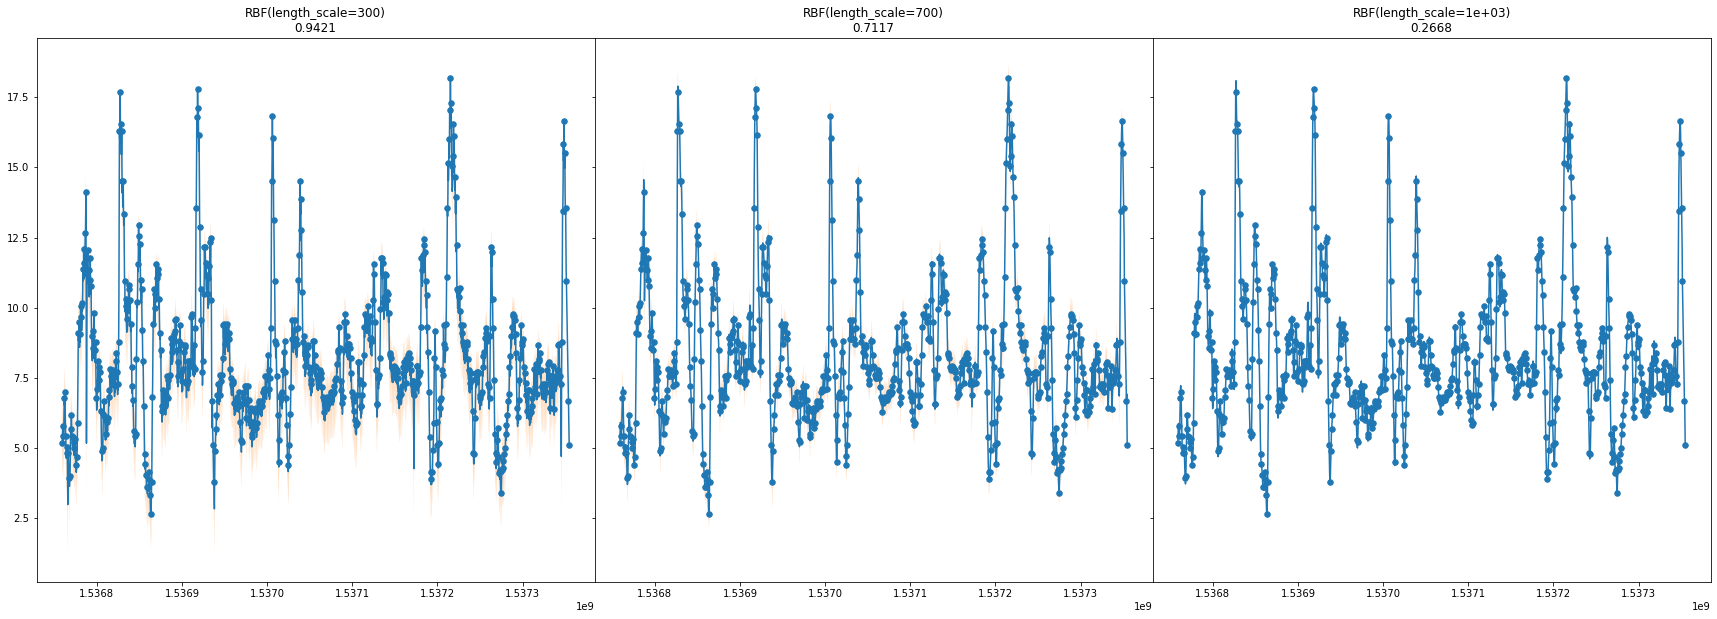

In [111]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
# Note I am NOT training these models. You can see in the bounds
# I am forcing them to have specific lengths. Normally, they would 
# fit to your data
kernels = [
    k.RBF(length_scale=300.0, length_scale_bounds=(300.0, 400.01)), 
    k.RBF(length_scale=700.0, length_scale_bounds=(500.0, 600.01)),
    k.RBF(length_scale=1000.0, length_scale_bounds=(700.0, 900.01)),
]

# Make some axes please
fig, axes = plt.subplots(figsize=(30, 10), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for kernel, ax in zip(kernels, axes):
    # Fit the GP, which doesnt do much as we fixed the length_scale
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X, y)
    
    # The 2D and [:, None] stuff is because the object expects 2D data in, not 1D
    y_mean, y_std = gp.predict(x1[:, None], return_std=True)

    ax.scatter(X, y, s=30, label="Samples", zorder=20)
    #ax.plot(x_fine, y_fine, label="Function", color="k", alpha=0.5)
    ax.plot(x1, y_mean)
    ax.fill_between(x1, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
    ax.set_title(f"{kernel}\n{y_std.max():0.4f}")


In [181]:
Y_train = idsingle.dropna().cut_glc

In [182]:
X_train = np.atleast_2d(idsingle.dropna(subset=['cut_glc']).timestamp).T

In [183]:
X_test = idsingle_test.timestamp

In [184]:
Y_test = idsingle_test.glc

In [162]:
X_train

array([[1.51490688e+09],
       [1.51490778e+09],
       [1.51490868e+09],
       [1.51490958e+09],
       [1.51491048e+09],
       [1.51491138e+09],
       [1.51491228e+09],
       [1.51491318e+09],
       [1.51491408e+09],
       [1.51491498e+09],
       [1.51491588e+09],
       [1.51491678e+09],
       [1.51491768e+09],
       [1.51491858e+09],
       [1.51491948e+09],
       [1.51492038e+09],
       [1.51492128e+09],
       [1.51492218e+09],
       [1.51492308e+09],
       [1.51492398e+09],
       [1.51492488e+09],
       [1.51492578e+09],
       [1.51492668e+09],
       [1.51492758e+09]])

In [27]:
Y_test.shape

(1311,)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

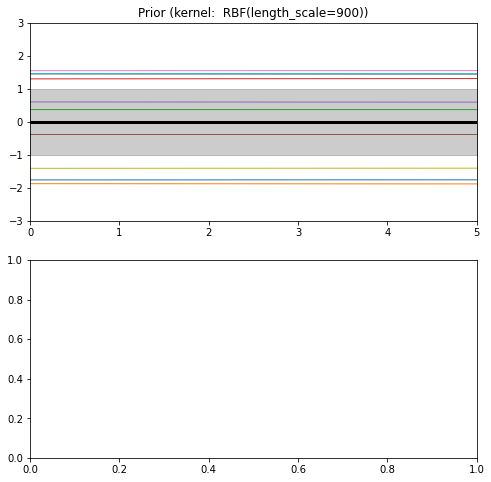

In [175]:

    # Specify Gaussian Process
    #gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    #X_ = np.linspace(0, 5, 100)
    
    y_mean, y_std = gp.predict(X_train, return_std=True)
    plt.plot(X_train, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_train, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_train, y_samples, lw=1)
    plt.scatter(X_train, y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

In [200]:
sub_df.head()

,time,glc,ID,cut_glc,glc_linear,glc_pchip,glc_spline,glc_akima,glc_poly_5,glc_poly_3,cut_glc_linear,cut_glc_pchip,cut_glc_spline,cut_glc_akima,cut_glc_poly_5,cut_glc_poly_3,timestamp
899427,2018-09-18 19:16:00,4.50,1004_6months,NaN,4.50,4.50,4.50,4.50,4.50,4.50,4.610000,4.596913,4.545181,4.604120,4.508423,4.545181,1.537298e+09
899432,2018-09-18 19:21:00,4.50,1004_6months,4.50,4.50,4.50,4.50,4.50,4.50,4.50,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,1.537298e+09
899437,2018-09-18 19:26:00,4.33,1004_6months,NaN,4.33,4.33,4.33,4.33,4.33,4.33,4.406667,4.416562,4.484351,4.405499,4.514175,4.484351,1.537299e+09
899442,2018-09-18 19:31:00,4.05,1004_6months,NaN,4.05,4.05,4.05,4.05,4.05,4.05,4.313333,4.338224,4.420819,4.318992,4.448666,4.420819,1.537299e+09
899447,2018-09-18 19:36:00,4.22,1004_6months,4.22,4.22,4.22,4.22,4.22,4.22,4.22,4.220000,4.220000,4.220000,4.220000,4.220000,4.220000,1.537299e+09


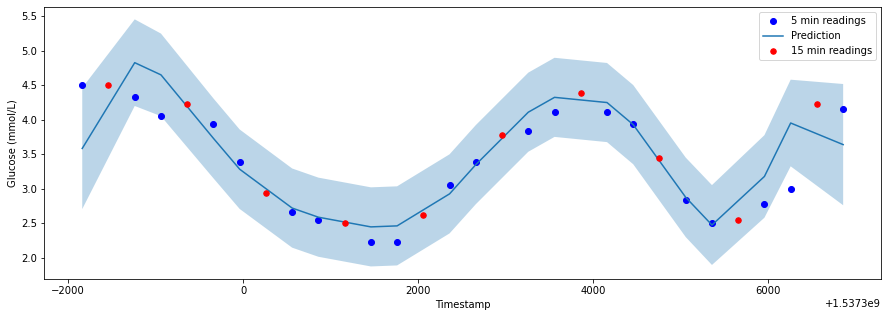

In [206]:
# Start at 2.0, fit a value between 1 and 10
kernel = k.RBF(length_scale=400, length_scale_bounds=(400, 600))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train, Y_train)
y_mean, y_std = gp.predict(X_test[:, None], return_std=True)

# Plot it all, yay
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(X_train, Y_train, color='r', s=30, label="15 min readings", zorder=20)
ax.plot(X_test, Y_test, 'bo', label="5 min readings")
ax.plot(X_test, y_mean, label='Prediction')
'''ax.plot(sub_df.timestamp, sub_df.cut_glc_spline, linewidth=0.5)
ax.plot(sub_df.timestamp, sub_df.cut_glc_akima, linewidth=0.5)
ax.plot(sub_df.timestamp, sub_df.cut_glc_pchip, linewidth=0.5)
ax.plot(sub_df.timestamp, sub_df.cut_glc_poly_5, linewidth=0.5)
ax.plot(sub_df.timestamp, sub_df.cut_glc_linear, linewidth=0.5)'''

ax.fill_between(X_test, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
#ax.set_title('Gaussian process, RBF kernel, length scale=700')
ax.legend()
ax.set_ylabel('Glucose (mmol/L)')
ax.set_xlabel('Timestamp')
#ax.set_title(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}");
# Note that the fitted kernel is inside the GP, the original kernel won't be modified
fig.savefig('../Results/Figs/gaussian_process.png')


ValueError: x and y must have same first dimension, but have shapes (1970,) and (1311,)

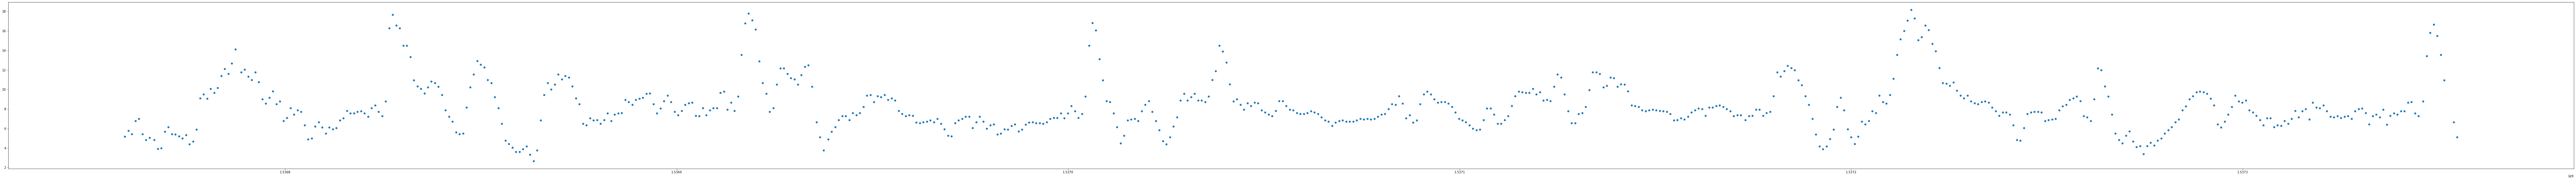

In [117]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1, 1500))
kernel = Matern(10, (1, 3500), 1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp.fit(X, y)
y_mean, y_std = gp.predict(np.atleast_2d(x1).T, return_std=True)

# Plot it all, yay
fig, ax = plt.subplots(figsize=(150, 10))
ax.scatter(X, y, s=30, label="Samples", zorder=20)
ax.plot(x1, y_act, 'rx', label="Actual")
ax.plot(x1, y_mean)
ax.fill_between(x1, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
ax.set_title(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}");
# Note that the fitted kernel is inside the GP, the original kernel w

In [224]:
V, p, dof, expected = stats.chi2_contingency(data) 
# add correction=False for uncorrected Chi-square

In [225]:
p

2.33819047130539e-05